# Paddle 运行UNet语义分割-动态图转静态图

In [1]:
# 安装paddleseg
! pip install -q paddleseg
# 解压数据集
#! mkdir /home/aistudio/DataSet
#! unzip -q /home/aistudio/data/data101908/IAILDdataset.zip -d DataSet

## 一、数据集预处理，及读取数据集

In [1]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import paddle
from paddle.nn import functional as F
import random
from paddle.io import Dataset
from visualdl import LogWriter
from paddle.vision.transforms import transforms as T
import warnings
warnings.filterwarnings("ignore")

import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def create_list(data_path):
    image_path = os.path.join(data_path, 'image')
    label_path = os.path.join(data_path, 'label')
    data_names = os.listdir(image_path)
    random.shuffle(data_names)  # 打乱数据
    with open(os.path.join(data_path, 'train_list.txt'), 'w') as tf:
        with open(os.path.join(data_path, 'val_list.txt'), 'w') as vf:
            for idx, data_name in enumerate(data_names):
                img = os.path.join('DataSet/image', data_name)
                lab = os.path.join('DataSet/label', data_name.replace('jpg', 'png'))
                if idx % 9 == 0:  # 90%的作为训练集
                    vf.write(img + ' ' + lab + '\n')
                else:
                    tf.write(img + ' ' + lab + '\n')
    print('数据列表生成完成')

data_path = 'DataSet'
create_list(data_path)  # 生成数据列表

import random
import os
import io
from paddle.io import Dataset
from paddle.vision.transforms import transforms as T
from PIL import Image as PilImage
import cv2
import numpy as np
import paddle
class dataset(paddle.io.Dataset):
    def __init__(self,mode):
        self.train_path = 'DataSet/train_list.txt'
        self.val_path='DataSet/val_list.txt'
        self.file_list = list()
        self.mode = mode
        self.image_size=(128,128)
        if mode == 'train':
            file_path = self.train_path
        elif mode == 'val':
            file_path = self.val_path
        with open(file_path, 'r') as f:
            for line in f:
                items = line.strip().split(' ')
                image_path = items[0]
                label_path = items[1]
                self.file_list.append([image_path, label_path])
    
    def _load_img(self, path, color_mode='rgb', transforms=[]):
        
        with open(path, 'rb') as f:
            img = PilImage.open(io.BytesIO(f.read()))
            if color_mode == 'grayscale':
                img = cv2.imread(f.name, cv2.IMREAD_GRAYSCALE)
                img = img.clip(max=1)
                img=Image.fromarray(cv2.cvtColor(img,cv2.IMREAD_GRAYSCALE))
                # w=img.size[0]
                # h=img.size[1]
                # for x in range(w):
                #     for y in range(h):
                #         L=img.getpixel((x,y))
                #         if(L==255):
                #             img.putpixel((x,y),(1)) 
            elif color_mode == 'rgba':
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')
            elif color_mode == 'rgb':
                if img.mode != 'RGB':
                    img = img.convert('RGB')
            else:
                raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')

            return T.Compose([
                T.Resize(self.image_size)
            ] + transforms)(img)
           
    def __getitem__(self, idx):
        image_path, label_path = self.file_list[idx]
        train_image = self._load_img(image_path,
                                     transforms=[
                                         T.Transpose(),
                                         T.Normalize(mean=127.5, std=127.5)
                                     ])
        label_image = self._load_img(label_path,
                                     color_mode='grayscale',
                                     transforms=[T.Grayscale()]) # 加载Label图像
  
        
       

        train_image = np.array(train_image, dtype='float32')
        label_image = np.array(label_image, dtype='int64')                              
        return train_image, label_image

    def __len__(self):
        return len(self.file_list)

train_dataset = dataset(mode='train')
val_dataset = dataset(mode='val')

print(val_dataset[50])

数据列表生成完成
(array([[[-0.04313726,  0.03529412,  0.01176471, ..., -0.04313726,
         -0.05098039, -0.07450981],
        [-0.02745098,  0.01960784, -0.01960784, ..., -0.01960784,
         -0.01960784, -0.03529412],
        [-0.00392157,  0.03529412, -0.04313726, ..., -0.01960784,
         -0.02745098, -0.05882353],
        ...,
        [-0.6       , -0.6       , -0.5921569 , ..., -0.01960784,
         -0.12941177, -0.22352941],
        [-0.6       , -0.6       , -0.6       , ..., -0.21568628,
         -0.23921569, -0.3647059 ],
        [-0.6       , -0.6       , -0.6       , ..., -0.42745098,
         -0.4745098 , -0.5058824 ]],

       [[-0.04313726,  0.03529412,  0.01176471, ..., -0.01176471,
         -0.01960784, -0.04313726],
        [-0.02745098,  0.01960784, -0.01960784, ...,  0.01176471,
          0.01176471, -0.00392157],
        [-0.00392157,  0.03529412, -0.04313726, ...,  0.01176471,
          0.00392157, -0.02745098],
        ...,
        [-0.5137255 , -0.5137255 , -0.505882

## 定义模型

### 动态图模型（与前面的静态图模型选一运行即可）

In [2]:
from paddle.nn import functional as F
from paddle.jit import to_static
class SeparableConv2D(paddle.nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=None,
                 weight_attr=None,
                 bias_attr=None,
                 data_format="NCHW"):
        super(SeparableConv2D, self).__init__()

        self._padding = padding
        self._stride = stride
        self._dilation = dilation
        self._in_channels = in_channels
        self._data_format = data_format

        # 第一次卷积参数，没有偏置参数
        filter_shape = [in_channels, 1] + self.convert_to_list(kernel_size, 2, 'kernel_size')
        self.weight_conv = self.create_parameter(shape=filter_shape, attr=weight_attr)

        # 第二次卷积参数
        filter_shape = [out_channels, in_channels] + self.convert_to_list(1, 2, 'kernel_size')
        self.weight_pointwise = self.create_parameter(shape=filter_shape, attr=weight_attr)
        self.bias_pointwise = self.create_parameter(shape=[out_channels],
                                                    attr=bias_attr,
                                                    is_bias=True)

    def convert_to_list(self, value, n, name, dtype=np.int):
        if isinstance(value, dtype):
            return [value, ] * n
        else:
            try:
                value_list = list(value)
            except TypeError:
                raise ValueError("The " + name +
                                "'s type must be list or tuple. Received: " + str(
                                    value))
            if len(value_list) != n:
                raise ValueError("The " + name + "'s length must be " + str(n) +
                                ". Received: " + str(value))
            for single_value in value_list:
                try:
                    dtype(single_value)
                except (ValueError, TypeError):
                    raise ValueError(
                        "The " + name + "'s type must be a list or tuple of " + str(
                            n) + " " + str(dtype) + " . Received: " + str(
                                value) + " "
                        "including element " + str(single_value) + " of type" + " "
                        + str(type(single_value)))
            return value_list

    def forward(self, inputs):
        conv_out = F.conv2d(inputs,
                            self.weight_conv,
                            padding=self._padding,
                            stride=self._stride,
                            dilation=self._dilation,
                            groups=self._in_channels,
                            data_format=self._data_format)

        out = F.conv2d(conv_out,
                       self.weight_pointwise,
                       bias=self.bias_pointwise,
                       padding=0,
                       stride=1,
                       dilation=1,
                       groups=1,
                       data_format=self._data_format)

        return out

class Encoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()

        self.relus = paddle.nn.LayerList(
            [paddle.nn.ReLU() for i in range(2)])
        self.separable_conv_01 = SeparableConv2D(in_channels,
                                                 out_channels,
                                                 kernel_size=3,
                                                 padding='same')
        self.bns = paddle.nn.LayerList(
            [paddle.nn.BatchNorm2D(out_channels) for i in range(2)])

        self.separable_conv_02 = SeparableConv2D(out_channels,
                                                 out_channels,
                                                 kernel_size=3,
                                                 padding='same')
        self.pool = paddle.nn.MaxPool2D(kernel_size=3, stride=2, padding=1)
        self.residual_conv = paddle.nn.Conv2D(in_channels,
                                              out_channels,
                                              kernel_size=1,
                                              stride=2,
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        y = self.relus[0](inputs)
        y = self.separable_conv_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.separable_conv_02(y)
        y = self.bns[1](y)
        y = self.pool(y)

        residual = self.residual_conv(previous_block_activation)
        y = paddle.add(y, residual)

        return y



class Decoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.relus = paddle.nn.LayerList(
            [paddle.nn.ReLU() for i in range(2)])
        self.conv_transpose_01 = paddle.nn.Conv2DTranspose(in_channels,
                                                           out_channels,
                                                           kernel_size=3,
                                                           padding=1)
        self.conv_transpose_02 = paddle.nn.Conv2DTranspose(out_channels,
                                                           out_channels,
                                                           kernel_size=3,
                                                           padding=1)
        self.bns = paddle.nn.LayerList(
            [paddle.nn.BatchNorm2D(out_channels) for i in range(2)]
        )
        self.upsamples = paddle.nn.LayerList(
            [paddle.nn.Upsample(scale_factor=2.0) for i in range(2)]
        )
        self.residual_conv = paddle.nn.Conv2D(in_channels,
                                              out_channels,
                                              kernel_size=1,
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        y = self.relus[0](inputs)
        y = self.conv_transpose_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.conv_transpose_02(y)
        y = self.bns[1](y)
        y = self.upsamples[0](y)

        residual = self.upsamples[1](previous_block_activation)
        residual = self.residual_conv(residual)

        y = paddle.add(y, residual)

        return y


class UNet(paddle.nn.Layer):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        self.conv_1 = paddle.nn.Conv2D(3, 32,
                                       kernel_size=3,
                                       stride=2,
                                       padding='same')
        self.bn = paddle.nn.BatchNorm2D(32)
        self.relu = paddle.nn.ReLU()

        in_channels = 32
        self.encoders = []
        self.encoder_list = [64, 128, 256]
        self.decoder_list = [256, 128, 64, 32]

        for out_channels in self.encoder_list:
            block = self.add_sublayer('encoder_{}'.format(out_channels),
                                      Encoder(in_channels, out_channels))
            self.encoders.append(block)
            in_channels = out_channels

        self.decoders = []

        for out_channels in self.decoder_list:
            block = self.add_sublayer('decoder_{}'.format(out_channels),
                                      Decoder(in_channels, out_channels))
            self.decoders.append(block)
            in_channels = out_channels

        self.output_conv = paddle.nn.Conv2D(in_channels,
                                            num_classes,
                                            kernel_size=3,
                                            padding='same')
   
    def forward(self, inputs):
        y = self.conv_1(inputs)
        y = self.bn(y)
        y = self.relu(y)

        for encoder in self.encoders:
            y = encoder(y)

        for decoder in self.decoders:
            y = decoder(y)

        y = self.output_conv(y)
        return y

### 静态图模型（与前面的动态图模型选一运行即可）

In [3]:
from paddle.nn import functional as F
from paddle.jit import to_static
class SeparableConv2D(paddle.nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=None,
                 weight_attr=None,
                 bias_attr=None,
                 data_format="NCHW"):
        super(SeparableConv2D, self).__init__()

        self._padding = padding
        self._stride = stride
        self._dilation = dilation
        self._in_channels = in_channels
        self._data_format = data_format

        # 第一次卷积参数，没有偏置参数
        filter_shape = [in_channels, 1] + self.convert_to_list(kernel_size, 2, 'kernel_size')
        self.weight_conv = self.create_parameter(shape=filter_shape, attr=weight_attr)

        # 第二次卷积参数
        filter_shape = [out_channels, in_channels] + self.convert_to_list(1, 2, 'kernel_size')
        self.weight_pointwise = self.create_parameter(shape=filter_shape, attr=weight_attr)
        self.bias_pointwise = self.create_parameter(shape=[out_channels],
                                                    attr=bias_attr,
                                                    is_bias=True)

    def convert_to_list(self, value, n, name, dtype=np.int):
        if isinstance(value, dtype):
            return [value, ] * n
        else:
            try:
                value_list = list(value)
            except TypeError:
                raise ValueError("The " + name +
                                "'s type must be list or tuple. Received: " + str(
                                    value))
            if len(value_list) != n:
                raise ValueError("The " + name + "'s length must be " + str(n) +
                                ". Received: " + str(value))
            for single_value in value_list:
                try:
                    dtype(single_value)
                except (ValueError, TypeError):
                    raise ValueError(
                        "The " + name + "'s type must be a list or tuple of " + str(
                            n) + " " + str(dtype) + " . Received: " + str(
                                value) + " "
                        "including element " + str(single_value) + " of type" + " "
                        + str(type(single_value)))
            return value_list

    def forward(self, inputs):
        conv_out = F.conv2d(inputs,
                            self.weight_conv,
                            padding=self._padding,
                            stride=self._stride,
                            dilation=self._dilation,
                            groups=self._in_channels,
                            data_format=self._data_format)

        out = F.conv2d(conv_out,
                       self.weight_pointwise,
                       bias=self.bias_pointwise,
                       padding=0,
                       stride=1,
                       dilation=1,
                       groups=1,
                       data_format=self._data_format)

        return out

class Encoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()

        self.relus = paddle.nn.LayerList(
            [paddle.nn.ReLU() for i in range(2)])
        self.separable_conv_01 = SeparableConv2D(in_channels,
                                                 out_channels,
                                                 kernel_size=3,
                                                 padding='same')
        self.bns = paddle.nn.LayerList(
            [paddle.nn.BatchNorm2D(out_channels) for i in range(2)])

        self.separable_conv_02 = SeparableConv2D(out_channels,
                                                 out_channels,
                                                 kernel_size=3,
                                                 padding='same')
        self.pool = paddle.nn.MaxPool2D(kernel_size=3, stride=2, padding=1)
        self.residual_conv = paddle.nn.Conv2D(in_channels,
                                              out_channels,
                                              kernel_size=1,
                                              stride=2,
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        y = self.relus[0](inputs)
        y = self.separable_conv_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.separable_conv_02(y)
        y = self.bns[1](y)
        y = self.pool(y)

        residual = self.residual_conv(previous_block_activation)
        y = paddle.add(y, residual)

        return y



class Decoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.relus = paddle.nn.LayerList(
            [paddle.nn.ReLU() for i in range(2)])
        self.conv_transpose_01 = paddle.nn.Conv2DTranspose(in_channels,
                                                           out_channels,
                                                           kernel_size=3,
                                                           padding=1)
        self.conv_transpose_02 = paddle.nn.Conv2DTranspose(out_channels,
                                                           out_channels,
                                                           kernel_size=3,
                                                           padding=1)
        self.bns = paddle.nn.LayerList(
            [paddle.nn.BatchNorm2D(out_channels) for i in range(2)]
        )
        self.upsamples = paddle.nn.LayerList(
            [paddle.nn.Upsample(scale_factor=2.0) for i in range(2)]
        )
        self.residual_conv = paddle.nn.Conv2D(in_channels,
                                              out_channels,
                                              kernel_size=1,
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        y = self.relus[0](inputs)
        y = self.conv_transpose_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.conv_transpose_02(y)
        y = self.bns[1](y)
        y = self.upsamples[0](y)

        residual = self.upsamples[1](previous_block_activation)
        residual = self.residual_conv(residual)

        y = paddle.add(y, residual)

        return y


class UNet(paddle.nn.Layer):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        self.conv_1 = paddle.nn.Conv2D(3, 32,
                                       kernel_size=3,
                                       stride=2,
                                       padding='same')
        self.bn = paddle.nn.BatchNorm2D(32)
        self.relu = paddle.nn.ReLU()

        in_channels = 32
        self.encoders = []
        self.encoder_list = [64, 128, 256]
        self.decoder_list = [256, 128, 64, 32]

        for out_channels in self.encoder_list:
            block = self.add_sublayer('encoder_{}'.format(out_channels),
                                      Encoder(in_channels, out_channels))
            self.encoders.append(block)
            in_channels = out_channels

        self.decoders = []

        for out_channels in self.decoder_list:
            block = self.add_sublayer('decoder_{}'.format(out_channels),
                                      Decoder(in_channels, out_channels))
            self.decoders.append(block)
            in_channels = out_channels

        self.output_conv = paddle.nn.Conv2D(in_channels,
                                            num_classes,
                                            kernel_size=3,
                                            padding='same')
    @to_static  #动静转换
    def forward(self, inputs):
        y = self.conv_1(inputs)
        y = self.bn(y)
        y = self.relu(y)

        for encoder in self.encoders:
            y = encoder(y)

        for decoder in self.decoders:
            y = decoder(y)

        y = self.output_conv(y)
        return y

In [4]:
IMAGE_SIZE = (128, 128)
num_classes = 2
network = UNet(num_classes)

#model = paddle.Model(network)
#model.summary((-1, 3,) + IMAGE_SIZE)

W0504 15:01:19.897287 14131 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0504 15:01:19.902781 14131 device_context.cc:422] device: 0, cuDNN Version: 7.6.


In [5]:
def get_color_map_list(num_classes):
    color_map = num_classes * [0, 0, 0]
    for i in range(0, num_classes):
        j = 0
        lab = i
        while lab:
            color_map[i * 3] |= (((lab >> 0) & 1) << (7 - j))
            color_map[i * 3 + 1] |= (((lab >> 1) & 1) << (7 - j))
            color_map[i * 3 + 2] |= (((lab >> 2) & 1) << (7 - j))
            j += 1
            lab >>= 3

    return color_map

color_map = get_color_map_list(2)


train_dataset = dataset(mode='train')
val_dataset = dataset(mode='val')

train_loader = paddle.io.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = paddle.io.DataLoader(val_dataset, batch_size=16, shuffle=True)


def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

## 开始训练（等待时间较长）

In [6]:
print('start training ... ')

EPOCH_NUM = 2
BATCH_SIZE = 1
train_num = 0

visual_IMAGE = Image.open('DataSet/image/1.jpg').resize((128, 128)).convert('RGBA')
visual_img = np.array(Image.open('DataSet/image/1.jpg').resize((128, 128)))
optimizer = paddle.optimizer.RMSProp(learning_rate=0.001, parameters=network.parameters())
normlize = (visual_img-127.5)/127.5
input = paddle.to_tensor([normlize.transpose(2, 0, 1)])

with LogWriter(logdir="./log") as writer:
    i = 0
    j = 0
    for epoch_id in range(EPOCH_NUM):
        loss_list_each_epoch = []
        network.train()
        for data, label in train_loader:
            i += 1
            y_pred = network(data)
            loss = F.cross_entropy(y_pred, label=label, axis=1)
            train_loss = loss.numpy()[0]
            loss.backward()
            optimizer.step()
            optimizer.clear_grad()
            predict_label = paddle.argmax(network(input)[0], axis=0).numpy().astype('uint64')
            pred_mask = Image.fromarray(predict_label, mode='P')
            pred_mask.putpalette(color_map)
            image = Image.blend(visual_IMAGE, pred_mask.convert('RGBA'), 0.3)
            acc, acc_cls, mean_iu, fwavacc =label_accuracy_score(label.numpy(), np.argmax(y_pred.numpy(), axis=1), 2)
            writer.add_image(tag="training Image", img=np.array(image), step=i)
            writer.add_scalar(tag="train/loss", step=i, value=train_loss)
            writer.add_scalar(tag="train/acc", step=i, value=acc)
            writer.add_scalar(tag="train/acc_cls", step=i, value=acc_cls)
            writer.add_scalar(tag="train/mean_iu", step=i, value=mean_iu)
            writer.add_scalar(tag="train/fwavacc", step=i, value=fwavacc)
            loss_list_each_epoch.append(train_loss)
        network.eval()
        val_loss_list_each_epoch = []
        for data, label in val_loader:
            j += 1
            y_pred = network(data)
            loss = F.cross_entropy(y_pred, label=label, axis=1)
            val_loss = loss.numpy()[0]
            acc, acc_cls, mean_iu, fwavacc =label_accuracy_score(label.numpy(), np.argmax(y_pred.numpy(), axis=1), 2)
            val_loss_list_each_epoch.append(val_loss)
            writer.add_scalar(tag="val/loss", step=j, value=val_loss)
            writer.add_scalar(tag="val/acc", step=j, value=acc)
            writer.add_scalar(tag="val/acc_cls", step=j, value=acc_cls)
            writer.add_scalar(tag="val/mean_iu", step=j, value=mean_iu)
            writer.add_scalar(tag="val/fwavacc", step=j, value=fwavacc)
        print("INFO:%d,Train Loss:%0.5f, Val Loss:%0.5f"%(epoch_id +1, np.average(loss_list_each_epoch), np.average(val_loss_list_each_epoch)))

start training ... 
INFO:1,Train Loss:1.52951, Val Loss:0.43075
INFO:2,Train Loss:0.43300, Val Loss:0.44719


## 可视化训练结果

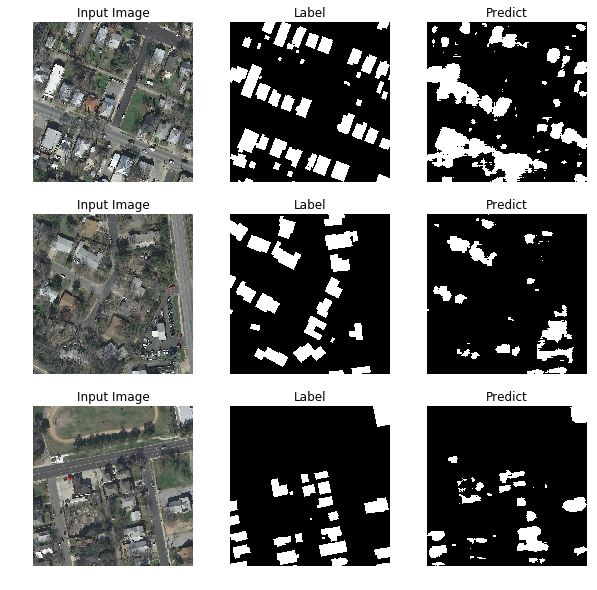

In [8]:
plt.figure(figsize=(10, 10))
IMAGE_SIZE = (512, 512)
i = 0
mask_idx = 0

with open('DataSet/val_list.txt', 'r') as f:
    for line in f.readlines():
        image_path, label_path = line.strip().split(' ')
        resize_t = T.Compose([
            T.Resize(IMAGE_SIZE)
        ])
        image = resize_t(Image.open(image_path))
        label = resize_t(Image.open(label_path))

        image = np.array(image).astype('uint8')
        label = np.array(label).astype('uint8')

        if i > 8:
            break
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title('Input Image')
        plt.axis("off")

        plt.subplot(3, 3, i + 2)
        plt.imshow(label, cmap='gray')
        plt.title('Label')
        plt.axis("off")

        # 模型只有一个输出，所以我们通过predict_results[0]来取出1000个预测的结果
        # 映射原始图片的index来取出预测结果，提取mask进行展示
        mask = paddle.argmax(network(paddle.to_tensor([((image - 127.5) / 127.5).transpose(2, 0, 1)]))[0], axis=0).numpy()

        plt.subplot(3,3, i + 3)
        plt.imshow(mask.astype('uint8'), cmap='gray')
        plt.title('Predict')
        plt.axis("off")
        i += 3
        mask_idx += 1

plt.show()